In [1]:
from glob import glob
import os
import pandas as pd
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib
import re

import sys
home=os.path.expanduser("~")
sys.path.append(os.path.join(home, 'station2grid'))

from tools import plotMap, CommonObj
%matplotlib inline

In [2]:
info = CommonObj().epa_station_info
info.head()

,SiteName,SiteEngName,area,lat,lon,lat_round,lon_round,row,col
0,大霸尖山,Dabajianshan,mountain,24.461111,121.249722,24.46,121.25,88,125
1,牧山,Mushan,mountain,23.864722,121.152222,23.86,121.15,148,115
2,玉山,Yushan,mountain,23.470556,120.948889,23.47,120.95,187,95
3,北大武山,Beidawushan,mountain,22.629167,120.751944,22.63,120.75,271,75
4,陽明,Yangming,city,25.182722,121.529583,25.18,121.53,16,153


# read

In [3]:
info = CommonObj().epa_station_info
info.head(1)


,SiteName,SiteEngName,area,lat,lon,lat_round,lon_round,row,col
0,大霸尖山,Dabajianshan,mountain,24.461111,121.249722,24.46,121.25,88,125


In [4]:
features_list = ['pm25',
#                  'pm25_AMBTEMP_RAINFALL_WINDCOS_WINDSIN',
#                  'pm25_AMBTEMP_RH_RAINFALL_WINDCOS_WINDSIN_PM10_NO2_SO2_O3'
                ]

station_list = [
#     'Cailiao'
    'Dabajianshan','Mushan','Yushan','Beidawushan',
    'Cailiao','Pingzhen','Tainan','Linyuan',
] #info.SiteEngName.values[:61]

In [5]:
def f(path):
    features = re.search('features-(.+?)--',path)
    features = features.group(1) if features!=None else 'pm25'
    
    c_type = re.search('composite_type-(.+?)--',path)
    c_type = c_type.group(1) if c_type!=None else 'x'

    val_stations = re.search('val_stations-(.+?)--',path).group(1)
    model_name = re.search('model_name-(.+?)--',path).group(1)
    composite_type = re.search('composite_type-(.+?)--',path)
    c1 = (features in features_list)
    c2 = (val_stations in station_list)
    c3 = (model_name in ['station2gridSD','knn','station2gridMD']) #['station2gridSD','knn','station2gridMD']
    c4 = (c_type in ['c0','c1','c2','c3','x'])
    return c1&c2&c3&c4
    
paths = glob(os.path.join('results','*csv'))
paths = [path for path in paths if f(path)==True]
paths = sorted(paths)

len(paths)
# paths


56

In [6]:
dfs = [pd.read_csv(path) for path in paths]

result = pd.concat(dfs, axis=0)
result.head()

,group,station,dt,predict,real
0,model_name-knn--val_stations-Beidawushan--k-4-...,Beidawushan,2019-01-01 00:00:00,29.325185,0.0
1,model_name-knn--val_stations-Beidawushan--k-4-...,Beidawushan,2019-01-01 01:00:00,29.374299,0.0
2,model_name-knn--val_stations-Beidawushan--k-4-...,Beidawushan,2019-01-01 02:00:00,31.700197,0.0
3,model_name-knn--val_stations-Beidawushan--k-4-...,Beidawushan,2019-01-01 03:00:00,29.288675,0.0
4,model_name-knn--val_stations-Beidawushan--k-4-...,Beidawushan,2019-01-01 04:00:00,28.319039,0.0


In [7]:
result.station.unique()


array(['Beidawushan', 'Cailiao', 'Dabajianshan', 'Linyuan', 'Mushan',
       'Pingzhen', 'Tainan', 'Yushan'], dtype=object)

# mse

In [8]:
# mean_squared_error

def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

def mape(y_true, y_pred): 
    eps = 1e-16
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true+eps))) * 100

In [9]:
by=['group', 'station'] #keys+['method','station']
df_mse=result.groupby(by).apply(lambda row: mean_squared_error(row.real, row.predict)).reset_index(name='value')
print(df_mse.shape)
df_mse.head()


(56, 3)


,group,station,value
0,model_name-knn--val_stations-Beidawushan--k-4-...,Beidawushan,625.426837
1,model_name-knn--val_stations-Cailiao--k-4--wei...,Cailiao,19.842513
2,model_name-knn--val_stations-Dabajianshan--k-4...,Dabajianshan,319.280889
3,model_name-knn--val_stations-Linyuan--k-4--wei...,Linyuan,46.642955
4,model_name-knn--val_stations-Mushan--k-4--weig...,Mushan,214.959632


In [10]:
site2area=dict(zip(info.SiteEngName,info.area,))
df_mse['area']=df_mse.station.apply(lambda x: site2area[x])
# df_mse

In [11]:
def parse(path, key='dnn_type'):
    match = re.search('(--|^)%s-(.+?)(--|$)'%(key), path)
    value = match.group(2) if match != None else '' ###
    return value
    
keys=['model_name','domain','composite_type'] # ['model_name','domain','k','weightKNN','composite_type','features']
for key in keys:
    df_mse[key] = df_mse.group.apply(lambda x: parse(x, key=key))
    
df_mse['method'] = df_mse.apply(
    lambda row: '-'.join([row[key] for key in keys]),axis=1)


In [12]:
df_mse.head(1)

,group,station,value,area,model_name,domain,composite_type,method
0,model_name-knn--val_stations-Beidawushan--k-4-...,Beidawushan,625.426837,mountain,knn,,,knn--


In [13]:
pivot=pd.pivot_table(df_mse, index=['station'], columns=['method','area']).reset_index()
pivot.head(1)

describe = pivot.describe().T.sort_values(by=['method'], ascending=True)
describe

count        mean         std         min  \
      method              area                                                  
value knn--               city        4.0   34.291050   11.136548   19.842513   
                          mountain    4.0  354.078471  185.910231  214.959632   
      station2gridMD--c0  city        4.0   33.612767   16.710942   14.626680   
                          mountain    4.0  364.845146  172.707883  156.019129   
      station2gridMD--c1  city        4.0   34.050614   15.974946   17.246526   
                          mountain    4.0  314.408559  125.244567  138.901156   
      station2gridMD--c2  city        4.0   35.475558   17.860814   18.440167   
                          mountain    4.0  314.575647  139.633403  137.949790   
      station2gridMD--c3  city        4.0   35.162461   17.784088   18.255723   
                          mountain    4.0  306.144362  141.228548  140.040986   
      station2gridSD-air- city        4.0   32.949955   12.537951   18.316312   
                          mountain    4.0  402.334295  179.390399  170.427096   
      station2gridSD-sat- city        4.0   48.711627   24.579048   22.639382   
                          mountain    4.0  300.405204   71.001200  209.503769   

                                           25%         50%         75%  \
      method              area                                           
value knn--               city       29.915317   35.339366   39.715099   
                          mountain  246.224804  287.963708  395.817376   
      station2gridMD--c0  city       27.523204   32.229941   38.319503   
                          mountain  306.610327  362.249954  420.484773   
      station2gridMD--c1  city       27.029598   31.636680   38.657695   
                          mountain  274.364353  344.934059  384.978265   
      station2gridMD--c2  city       27.929382   31.408191   38.954367   
                          mountain  266.802538  320.765821  368.538930   
      station2gridMD--c3  city       27.841580   31.070914   38.391795   
                          mountain  246.227093  300.497290  360.414559   
      station2gridSD-air- city       28.048617   32.288702   37.190040   
                          mountain  347.963612  415.480956  469.851638   
      station2gridSD-sat- city       39.293776   45.114889   54.532740   
                          mountain  271.907127  305.632406  334.130484   

                                           max  
      method              area                  
value knn--               city       46.642955  
                          mountain  625.426837  
      station2gridMD--c0  city       55.364504  
                          mountain  578.861547  
      station2gridMD--c1  city       55.682569  
                          mountain  428.864961  
      station2gridMD--c2  city       60.645682  
                          mountain  478.821155  
      station2gridMD--c3  city       60.252295  
                          mountain  483.541881  
      station2gridSD-air- city       48.906102  
                          mountain  607.948171  
      station2gridSD-sat- city       81.977351  
                          mountain  380.852237

# plot

## mountain

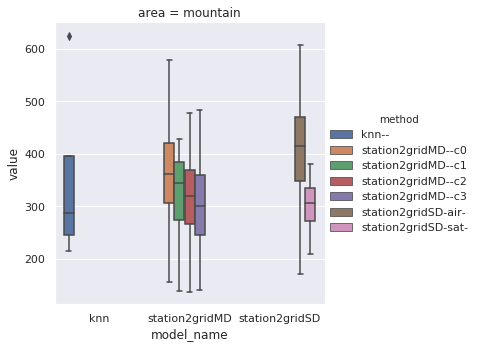

In [14]:
sns.set(font_scale=1)
ax = sns.catplot(
    x='model_name', 
    y='value', 
    col='area',
    hue='method', 
    data=df_mse[df_mse.station.isin(station_list[:4])],
    kind='box',
#     order=order,
#     height=4,
#     aspect=2,
    legend=True
)
ax.set_xticklabels(rotation=0)
# plt.ylim(0, 80)
# plt.legend(bbox_to_anchor=(1, 1.6))

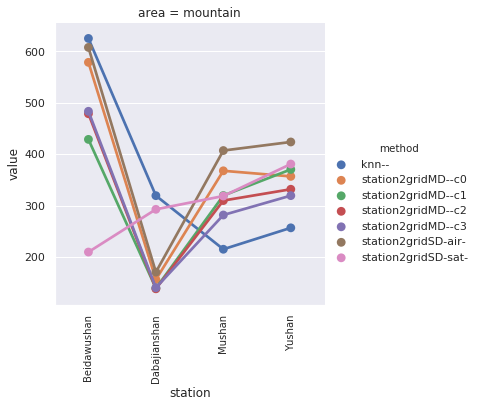

In [19]:
sns.set(font_scale=1)
ax = sns.catplot(
    x='station', 
    y='value', 
    col='area',
    hue='method', 
    data=df_mse[df_mse.station.isin(station_list[:4])],
    kind='point',
#     order=station_list[:],
#     height=4,
#     aspect=4,
    legend=True,
    linestyles='-',
)

ax.set_xticklabels(rotation=90, size=10)
# plt.ylim(30, 35)
# plt.legend(bbox_to_anchor=(1, 1.6))
# plt.grid(axis='x')

## city

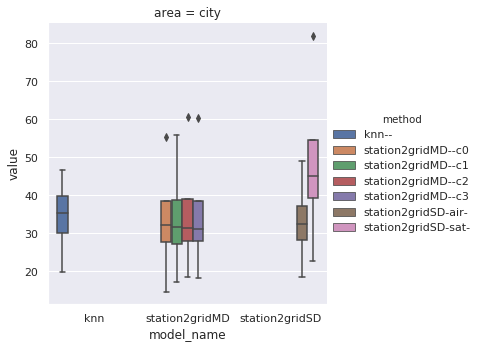

In [16]:
sns.set(font_scale=1)
ax = sns.catplot(
    x='model_name', 
    y='value', 
    col='area',
    hue='method', 
    data=df_mse[df_mse.station.isin(station_list[4:])],
    kind='box',
#     order=order,
#     height=4,
#     aspect=2,
    legend=True
)
ax.set_xticklabels(rotation=0)
# plt.ylim(0, 80)
# plt.legend(bbox_to_anchor=(1, 1.6))

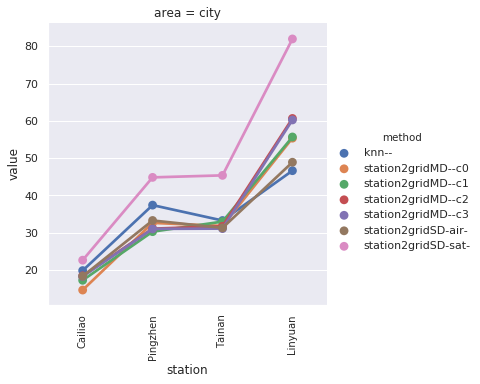

In [17]:
sns.set(font_scale=1)
ax = sns.catplot(
    x='station', 
    y='value', 
    col='area',
    hue='method', 
    data=df_mse[df_mse.station.isin(station_list[4:])],
    kind='point',
    order=station_list[4:],
#     height=4,
#     aspect=4,
    legend=True,
    linestyles='-',
)

ax.set_xticklabels(rotation=90, size=10)
# plt.ylim(30, 35)
# plt.legend(bbox_to_anchor=(1, 1.6))
# plt.grid(axis='x')